In [106]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper
from time import sleep
import numpy as np

## Load Data

- Created a batch of 1200 for training set and 90 for test set
- 0 means Rose
- 1 means Sunflower

In [107]:
data_dir = '/home/rohit/Desktop/flowers'
 # batch size
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize((255, 255)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      ])

test_transforms = transforms.Compose([transforms.Resize((255, 255)),
                                     transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=1200, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=90)

## Iterate through all images in batch
1. Defined dataload
2. Flatten images
3. Intialized weights and biases to zeros
4. Transferred all tensors to GPU

In [118]:
def dataload(loader,m):    
    data_iter = iter(loader)
    images, labels = next(data_iter)
    print('initial image size = ', images.shape)
    images = images.reshape(m,-1).t() /255
    print('flattened image size = ', images.shape)
    (nx,m) = images.shape # m is no of training exmples 
    return images,labels,nx,m

In [119]:
images,labels,nx,m = dataload(trainloader,1200)
X = images.cuda() # (nx x m)
Y = labels.cuda() 
Y = torch.reshape(Y,(1,m)) # (1 x m)
Y = Y.float().cuda()

initial image size =  torch.Size([1200, 3, 255, 255])
flattened image size =  torch.Size([195075, 1200])


In [120]:
w = torch.zeros((nx,1)).cuda() #weights
b = torch.zeros(1).cuda()#biases

In [121]:
images,labels,nx,n = dataload(testloader,90)
X_test = images.cuda() # (nx x m)
Y_test = labels.cuda() 
Y_test = torch.reshape(Y_test,(1,n)) # (1 x m)
Y_test = Y_test.float().cuda()

initial image size =  torch.Size([90, 3, 255, 255])
flattened image size =  torch.Size([195075, 90])


## Helper functions





$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

In [122]:
def sigmoid(x):
    return (1 / (1+torch.exp(-x)))

## Forward Propagation:

- Get X
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Formulas:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [123]:
def parameters(w, b, X, Y):
    A = sigmoid(torch.mm(w.t(), X)+b) # dimension (1 x m)
    cost = -(torch.mm(Y , torch.log(A.t())) + torch.mm((1-Y) , torch.log( (1-A).t() ) )) / m
    dz = A - Y
    db = (torch.sum(dz))  /  m
    dw = torch.mm(X, dz.t())
    
    assert(dw.shape == w.shape)
    
    return cost,dw,db

## Predicition 

In [124]:
def predict(w,b,X):
    A = sigmoid(torch.mm(w.t(), X)+b)
    
    Y_prediction = torch.zeros((1,X.shape[1])).cuda()
    for i in range(X.shape[1]):
        
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    return Y_prediction

## Training the model

Given an initial value of weights, biases, iteration and learning rate, the below block of code will try to
optimize the values of weight and biases such that we get a higher training accuracy.

In [125]:
def optimize(w, b, X, X_test, Y, num_iterations, alpha ):
    
    cost_arr = []
    Y_p_train = []
    Y_p_test = []
    for i in range(num_iterations):
        
        cost,dw,db = parameters(w, b, X, Y)
        w = w - alpha * dw
        b = b - alpha * db
        
        if num_iterations % 1000 == 0:
            cost_arr.append(cost)
            
            Y_prediction_train = predict(w, b, X)
            t1 = 100 - torch.mean(torch.abs(Y_prediction_train - Y)) * 100
            Y_p_train.append(t1)
            
            Y_prediction_test = predict(w, b, X_test)
            t2 = 100 - torch.mean(torch.abs(Y_prediction_test - Y_test)) * 100
            Y_p_test.append(t2)
            # print("test accuracy: ", t2, "train accuracy: ",t1)
    
    return cost_arr, w, b, Y_p_train, Y_p_test

# Calculation of Test and Train Accuracy

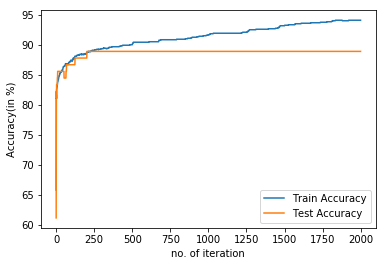

In [126]:
cost_arr, w, b, Y_p_train, Y_p_test = optimize(w, b, X, X_test, Y, 2000, 0.01)
plt.ylabel('Accuracy(in %)')
plt.xlabel('no. of iteration')
plt.plot(Y_p_train, label = 'Train Accuracy')
plt.plot(Y_p_test, label ='Test Accuracy')
plt.legend()

In [127]:
print("Train Accuracy: ", float(Y_p_train[-1]), "\t Test Accuracy: ", float(Y_p_test[-1]))

Train Accuracy:  94.08333587646484 	 Test Accuracy:  88.88888549804688


## Test your own image